 - Life Lone Learning
 - Elastic Weight Consolidation (EWC)
    - [教學](https://www.kaggle.com/code/hughiephan/elastic-weight-consolidation-on-minst)
    - [Paper](https://arxiv.org/pdf/1612.00796)
    - 公式 $\mathcal{L}(\theta) = \mathcal{L}_B(\theta) + \frac\lambda2\sum^n_{i=1}F_i(\theta_i - \theta^*_{A,i})^2$
        - B是指目前任務，A是指前一個任務
 - [教學2](https://github.com/ContinualAI/colab/blob/master/notebooks/intro_to_continual_learning.ipynb)

In [2]:
import torch
from torch import nn
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation, Lambda
import numpy as np
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.nn import CrossEntropyLoss
from torch.optim import Adam, SGD
from torch.nn.functional import cross_entropy

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
batch_size = 256
epochs = 15
task = 2

 - [ToTensor](https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html)

In [5]:
def trans_compose(i=0):
    return Compose([
        # lambda x : np.rot90(x, i, axes=[0, 1]).copy(), # 使連續
        # lambda x: np.expand_dims(x, axis=-1),  # 因為ToTensor要PIL or ndarray(H x W x C)，之後轉成Tensor(C x H x W)
        ToTensor(),
        # Lambda(lambda x : x / 255.), 
        RandomRotation((90 * i, 90 * i)),
        Normalize(mean=[0.0], std=[1])
    ])

In [6]:
# preprocessing
# train_task_1 = FashionMNIST('data', train=True, transform=trans_compose(0), download=True)
# train_task_2 = FashionMNIST('data', train=True, transform=trans_compose(1), download=True)

test_task_1 = FashionMNIST('data', train=False, transform=trans_compose(0), download=True)
test_task_2 = FashionMNIST('data', train=False, transform=trans_compose(1), download=True)

task_1_loader = DataLoader(test_task_1, batch_size=batch_size)
task_2_loader = DataLoader(test_task_2, batch_size=batch_size)

In [7]:
class Module(nn.Module):
    def __init__(self):
        super(Module, self).__init__()
        # self.classifier = nn.Sequential(
        #     nn.Conv2d(1, 10, kernel_size=5), 
        #     nn.MaxPool2d(2),
        #     nn.ReLU(),
        #     nn.Conv2d(10, 20, kernel_size=5),
        #     nn.Dropout2d(),
        #     nn.MaxPool2d(2),
        #     nn.ReLU(),
        # )
        # self.dense = nn.Sequential(
        #     nn.Linear(320, 50),
        #     nn.ReLU(),
        #     nn.Dropout(),
        #     nn.Linear(50, 10)
        # )
        self.net = nn.Sequential(
            nn.Flatten(), 
            nn.LazyLinear(10)
        )
    def forward(self, X):
        # return self.dense(self.classifier(X).view(-1, 320))
        return self.net(X)

In [8]:
def evaluate(model, dataloader, num_data, num_task=-1):
    if num_task < 0: raise ValueError("Task Number is Missing")
    
    test_acc = 0
    test_loss = 0
    with torch.no_grad():
        model.eval()
        for data in dataloader:
            img, label = data
            img, label = img.to(device), label.to(device).long()
            output = model(img)
            test_loss += cross_entropy(output, label)
            test_acc += (output.argmax(1) == label).sum()
    print('\033[33m' + 
          f'Task {num_task} Acc: {test_acc / num_data: .4f}, Loss: {test_loss / num_data: .4f}' + 
          '\033[0m')

In [9]:
def training_Setting(model):
    optimizer = Adam(model.parameters())
    loss = CrossEntropyLoss()
    return optimizer, loss

 - Fisher Matrix
     - 儲存權重對模型重要性
     - 計算方法
         - [LINK](https://github.com/db434/EWC)
             - 這個版本是**取樣** $\rightarrow$ 計算梯度
         - 這邊的範例程式碼是直接**整個資料**來計算梯度
         - 公式
             - $F_j = \frac1m \sum^m_{i=1}(\frac{\partial \log (P(x_i|\theta_j))}{\partial \theta_j})^2$

In [10]:
# EWC
optim_para = {}
fisher_matrix = {}
ewc_lambda = 0 #27

def record_parameter(model, train_data, optimizer, num_task=-1):
    if num_task < 0: raise ValueError("Task Number is Missing")
    global optim_para, fisher_matrix, ewc_lambda
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    model.train()
    optimizer.zero_grad()

    fisher_matrix[num_task] = {}
    optim_para[num_task] = {}

    # Initialize Fisher Matrix
    for name, param in model.named_parameters():
        fisher_matrix[num_task][name] = torch.zeros_like(param.data)

    # Calculate Fisher Matrix
    for data in train_loader:
        img, label = data
        img, label = img.to(device), label.to(device).long()
        output = model(img)
        output_loss = cross_entropy(output, label)
        output_loss.backward()

        for name, param in model.named_parameters():
            if param.grad is not None:
                fisher_matrix[num_task][name] += param.grad.data.clone().pow(2)

    # Average Fisher Matrix
    for name, param in model.named_parameters():
        fisher_matrix[num_task][name] /= len(train_loader)

    # Save optimal parameters
    for name, param in model.named_parameters():
        optim_para[num_task][name] = param.data.clone()

In [11]:
def training(model, test_loader : list, test_num : list, epochs = 10,  num_task=-1):
    if num_task < 0: raise ValueError("Task Number is Missing")
    global optim_para, fisher_matrix, ewc_lambda
    print(f'Task {num_task} Start!')
    
    train_data = FashionMNIST('data', train=True, transform=trans_compose(num_task), download=True)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    plt.imshow(train_data[0][0].reshape(28, 28), cmap='gray')
    plt.title('Task' + str(num_task))
    plt.show()
    
    # optimizer, loss = training_Setting(model)
    optimizer = Adam(model.parameters())
    
    for i in range(epochs):
        model.train()
        train_acc = 0
        train_loss = 0
        for data in train_loader:
            optimizer.zero_grad()
            
            img, label = data
            img, label = img.to(device), label.to(device).long()
            output = model(img)
            output_loss = cross_entropy(output, label)
            # Record
            train_acc += (output.argmax(1) == label).sum()
            # BP
            ewc_loss = 0
            for t in range(num_task):
                for name, param in model.named_parameters():
                    if t in optim_para:
                        fisher = fisher_matrix[t][name]
                        optim = optim_para[t][name]
                        if fisher.requires_grad == True or optim.requires_grad == True: 
                            raise NotImplementedError('Frozen it!')
                        # output_loss += ewc_lambda * (fisher * (optim - param).pow(2)).sum() # .detach()
                        ewc_loss += (fisher * (optim - param).pow(2)).sum() * ewc_lambda
            # if tmp != 0: print(tmp)
            output_loss += ewc_loss
            train_loss += output_loss.detach()
            output_loss.backward()
            optimizer.step()            
        print(f'Epoch\t{i + 1}\tAcc: {train_acc / len(train_data): .4f}, Loss: {train_loss / len(train_data): .4f}')
    record_parameter(model, train_data, optimizer, num_task=num_task)
    # Evaluate Task 0 & 1
    task_id = 0
    for num_data, loader in zip(test_num, test_loader):
        evaluate(model, loader, num_data, task_id)
        task_id = task_id + 1
    print() # End of Training

 - nn.Module
    - named_pa​​rameters()
         - 給出網絡層的名字和參數的迭代器
    - parameters()
         - 參數的迭代器
    - [Reference](https://blog.csdn.net/qq_36530992/article/details/102729585)

Task 0 Start!


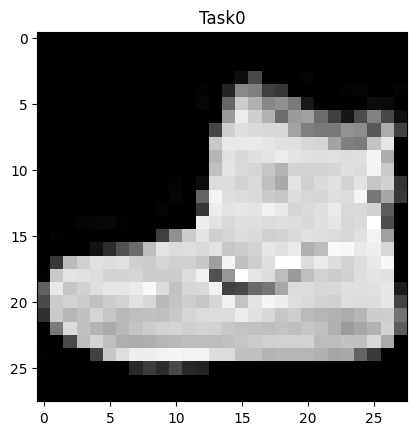

Epoch	1	Acc:  0.7352, Loss:  0.0033
Epoch	2	Acc:  0.8157, Loss:  0.0022
Epoch	3	Acc:  0.8306, Loss:  0.0020
Epoch	4	Acc:  0.8405, Loss:  0.0019
Epoch	5	Acc:  0.8456, Loss:  0.0018
Epoch	6	Acc:  0.8495, Loss:  0.0018
Epoch	7	Acc:  0.8510, Loss:  0.0017
Epoch	8	Acc:  0.8541, Loss:  0.0017
Epoch	9	Acc:  0.8546, Loss:  0.0017
Epoch	10	Acc:  0.8567, Loss:  0.0016
Epoch	11	Acc:  0.8579, Loss:  0.0016
Epoch	12	Acc:  0.8585, Loss:  0.0016
Epoch	13	Acc:  0.8608, Loss:  0.0016
Epoch	14	Acc:  0.8612, Loss:  0.0016
Epoch	15	Acc:  0.8621, Loss:  0.0016
Task 0 Acc:  0.8439, Loss:  0.0018
Task 1 Acc:  0.0271, Loss:  0.0367

Task 1 Start!


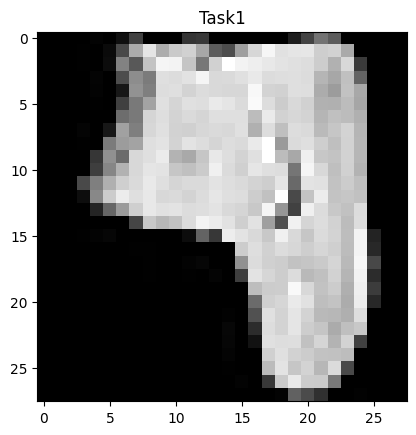

Epoch	1	Acc:  0.4716, Loss:  0.0092
Epoch	2	Acc:  0.7337, Loss:  0.0031
Epoch	3	Acc:  0.7896, Loss:  0.0024
Epoch	4	Acc:  0.8143, Loss:  0.0022
Epoch	5	Acc:  0.8272, Loss:  0.0020
Epoch	6	Acc:  0.8351, Loss:  0.0019
Epoch	7	Acc:  0.8414, Loss:  0.0018
Epoch	8	Acc:  0.8451, Loss:  0.0018
Epoch	9	Acc:  0.8485, Loss:  0.0018
Epoch	10	Acc:  0.8514, Loss:  0.0017
Epoch	11	Acc:  0.8537, Loss:  0.0017
Epoch	12	Acc:  0.8550, Loss:  0.0017
Epoch	13	Acc:  0.8557, Loss:  0.0017
Epoch	14	Acc:  0.8572, Loss:  0.0016
Epoch	15	Acc:  0.8582, Loss:  0.0016
Task 0 Acc:  0.0634, Loss:  0.0357
Task 1 Acc:  0.8393, Loss:  0.0018



In [12]:
model = Module().to(device)

for i in range(task):
    training(model, [task_1_loader, task_2_loader], [len(test_task_1), len(test_task_2)], num_task=i, epochs=epochs)

Accuracy 0.8393
Classification Report
              precision    recall  f1-score   support

 T-shirt/top       0.80      0.82      0.81      1000
     Trouser       0.98      0.95      0.97      1000
    Pullover       0.68      0.77      0.72      1000
       Dress       0.85      0.85      0.85      1000
        Coat       0.73      0.74      0.73      1000
      Sandal       0.95      0.91      0.93      1000
       Shirt       0.63      0.53      0.57      1000
     Sneaker       0.90      0.93      0.92      1000
         Bag       0.94      0.94      0.94      1000
  Ankle boot       0.94      0.95      0.94      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



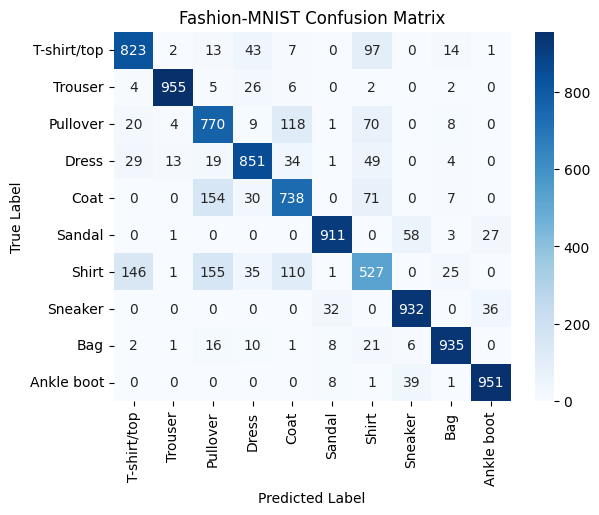

In [16]:
true_label = []
pred_label = []
with torch.no_grad():
    for data in task_2_loader:
        img, label = data
        output = model(img).argmax(1)
        true_label.extend(label.numpy())
        pred_label.extend(output.numpy())
        
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('\033[33m' + 'Accuracy' + '\033[0m', accuracy_score(true_label, pred_label))
print('\033[33m' + 'Classification Report' + '\033[0m',
      classification_report(true_label, pred_label, target_names=test_task_2.classes), 
      sep='\n')
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_label, pred_label)
plt.cla(); plt.clf()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_task_2.classes, yticklabels=test_task_2.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Fashion-MNIST Confusion Matrix")
plt.show()

net.1.weight
torch.Size([10, 784])


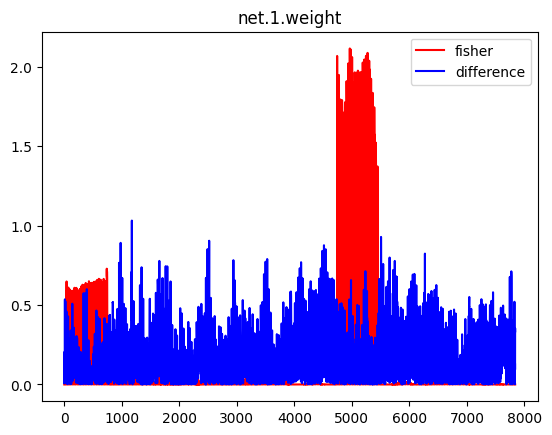


net.1.bias
torch.Size([10])


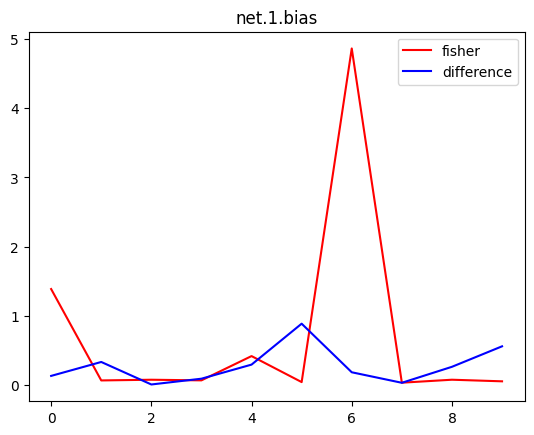

In [13]:
# test
idx = 0
for name, param in model.named_parameters():
  plt.cla(); plt.clf()
  plt.title(name)
  
  # Name
  print(name)
  print(param.detach().shape)
  
  fisher = fisher_matrix[0][name].detach()
  optim = optim_para[0][name].detach()
  param = param.detach()
  plt.plot(fisher.reshape(-1), 'r', label='fisher')
  plt.plot((optim - param).abs().reshape(-1), 'b', label='difference')
  plt.legend()
  plt.show()

  # END
  idx += 1
  print()